# Exercise 5.2

This notebook aims to respond to point 5.2 of the script `SISTCA_2023-24_Lab_Script_Template_V3_19May2024`.

In exercise 5.2, the reader must analyze the vegetation of a given region using the `NDVI` Normalized Difference Vegetation Index. You should use the coordinates `(-52.6490,-23.1770,-52.5977,-23.1449)`, the time interval should be `'2022-01-01/2022-12-30'` and you should use Sentinel2 data `'S2-16D-2'`.

Installing Packages and Dependencies

In [1]:
import pystac_client

In [2]:
from wtss import *

In [3]:
%matplotlib inline
from matplotlib import pyplot as plt

In [4]:
import rasterio
from rasterio.crs import CRS
from rasterio.warp import transform
from rasterio.windows import from_bounds

Connection to the Brazil Data Cube API

To perform the necessary operations, you must use the `pystac_client` API. To find out all about its features, you can consult [STAC client for Python](https://github.com/brazil-data-cube/stac.py).

In [5]:
# function taken from Brazil Data Cube's GitHub code gallery

def read(uri: str, bbox: list, masked: bool = True, crs: str = None):
    """Read raster window as numpy.ma.masked_array."""
    source_crs = CRS.from_string('EPSG:4326')
    if crs:
        source_crs = CRS.from_string(crs)

    # Expects the bounding box has 4 values
    w, s, e, n = bbox
        
    with rasterio.open(uri) as dataset:
        transformer = transform(source_crs, dataset.crs, [w, e], [s, n])
        window = from_bounds(transformer[0][0], transformer[1][0], 
                             transformer[0][1], transformer[1][1], dataset.transform)
        return dataset.read(1, window=window, masked=masked)
    


In [6]:
token = 'r5p7J7kpqIbnPY47jX4i8YfaVcKq7iPFsO3nQQ6OpF'    #Change to your token

In [7]:
parameters = dict(access_token=token)
service_STAC = pystac_client.Client.open('https://brazildatacube.dpi.inpe.br/stac/', parameters=parameters)

In [8]:
service_WTSS = WTSS('https://brazildatacube.dpi.inpe.br/', 
               access_token=token)

In [9]:
satelite = 'S2-16D-2'  #Satellite selection

In [10]:
service_STAC.get_collection(satelite).get_items() 

<generator object CollectionClient.get_items at 0x7f33f36571b0>

Then you can search for the features you want

In [11]:
bbox=(-52.6490,-23.1770,-52.5977,-23.1449)

item_search = service_STAC.search(bbox=bbox,
                             datetime='2022-01-01/2022-12-30',
                             collections=[satelite])

item_search.matched() #numero de ficheiros de informação disponiveis com estas defenições

#bbox = dimensoes do quadrado de pesquisa a obter em conjunto com o mapa do BDC
#datetime = linha temporal pertendida a obter os ficheiros de informação
#collections= satelite que ira fornecer a informação

18

In [12]:
counter = 0
for item in item_search.get_items():    #listagem de ficheiros de informação disponiveis 
    print(f"[{counter}].  {item}")
    counter += 1

[0].  <Item id=S2-16D_V2_023030_20220930>
[1].  <Item id=S2-16D_V2_023030_20220914>
[2].  <Item id=S2-16D_V2_023030_20220829>
[3].  <Item id=S2-16D_V2_023030_20220813>
[4].  <Item id=S2-16D_V2_023030_20220728>
[5].  <Item id=S2-16D_V2_023030_20220712>
[6].  <Item id=S2-16D_V2_023030_20220626>
[7].  <Item id=S2-16D_V2_023030_20220610>
[8].  <Item id=S2-16D_V2_023030_20220525>
[9].  <Item id=S2-16D_V2_023030_20220509>
[10].  <Item id=S2-16D_V2_023030_20220423>
[11].  <Item id=S2-16D_V2_023030_20220407>
[12].  <Item id=S2-16D_V2_023030_20220322>
[13].  <Item id=S2-16D_V2_023030_20220306>
[14].  <Item id=S2-16D_V2_023030_20220218>
[15].  <Item id=S2-16D_V2_023030_20220202>
[16].  <Item id=S2-16D_V2_023030_20220117>
[17].  <Item id=S2-16D_V2_023030_20220101>


In [13]:
items = list(item_search.get_items()) #Listagem dos items num array com o nome items

Read data band by band using the read function

In [14]:
red = read(item.assets['B04'].href, bbox=bbox)         
nir = read(item.assets['B08'].href, bbox=bbox)

## NDVI calculation

$$
NDVI = \frac{(NIR - RED)}{(NIR + RED)}
$$

<center><b>Equation 1</b> - NDVI.</center>

In [15]:
ndvi = (nir - red)/(nir + red)
ndvi

masked_array(
  data=[[0.6316896471138116, 0.6332163742690059, 0.6355912202029738, ...,
         0.3260105448154657, 0.34099616858237547, 0.3651393481341521],
        [0.6256983240223464, 0.6250884225418534, 0.6267303102625298, ...,
         0.35130278526504943, 0.33683010262257695, 0.3433734939759036],
        [0.6332310597120604, 0.6299496040316774, 0.6300242130750605, ...,
         0.42355089000456414, 0.41911764705882354, 0.4268434519655734],
        ...,
        [0.5333792154163799, 0.5580541532813217, 0.5579958819492107, ...,
         0.6584988393087439, 0.6508264462809917, 0.6325254104769351],
        [0.5275806820782788, 0.5493087557603686, 0.5521839080459771, ...,
         0.6625099495887503, 0.6383975026014568, 0.6013461040641989],
        [0.5252387448840382, 0.5505823247316739, 0.5345454545454545, ...,
         0.6345692184582555, 0.6222974733003386, 0.5997939737316508]],
  mask=[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, Fals

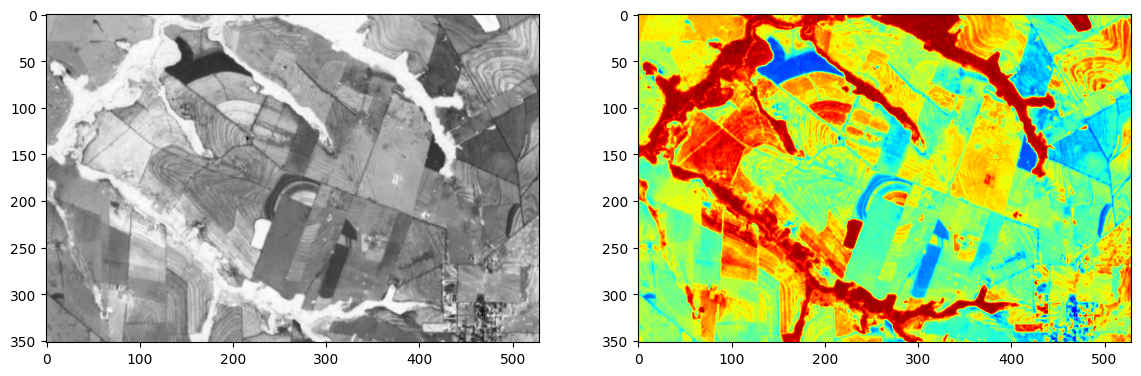

In [16]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(14, 14)) #Plot em gray e jet

ax1.imshow(ndvi, cmap='gray')
ax2.imshow(ndvi, cmap='jet')

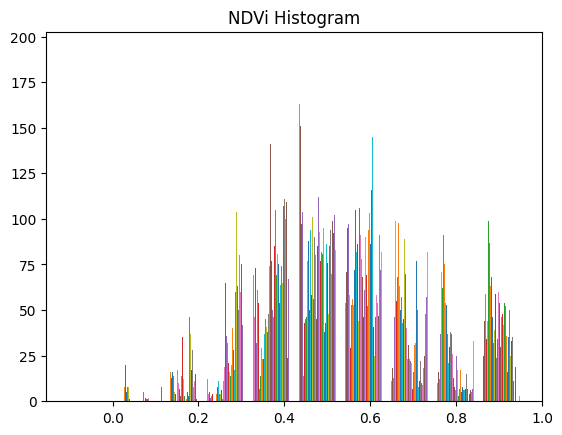

In [17]:
plt.title("NDVi Histogram") #Ciração do histograma do ndvi
plt.hist(ndvi)
plt.show()

We can use the histogram above to apply threshold values  

In [18]:
labeled_img = ndvi.copy() 

In [19]:
labeled_img[ndvi < 0.2] = 1 # < 0.2
labeled_img[ndvi >= 0.2] = 3 # 0.2 - 0.65
labeled_img[ndvi >= 0.65] = 2 # >= 0.65
labeled_img

masked_array(
  data=[[3.0, 3.0, 3.0, ..., 3.0, 3.0, 3.0],
        [3.0, 3.0, 3.0, ..., 3.0, 3.0, 3.0],
        [3.0, 3.0, 3.0, ..., 3.0, 3.0, 3.0],
        ...,
        [3.0, 3.0, 3.0, ..., 2.0, 2.0, 3.0],
        [3.0, 3.0, 3.0, ..., 2.0, 3.0, 3.0],
        [3.0, 3.0, 3.0, ..., 3.0, 3.0, 3.0]],
  mask=[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],
  fill_value=0)

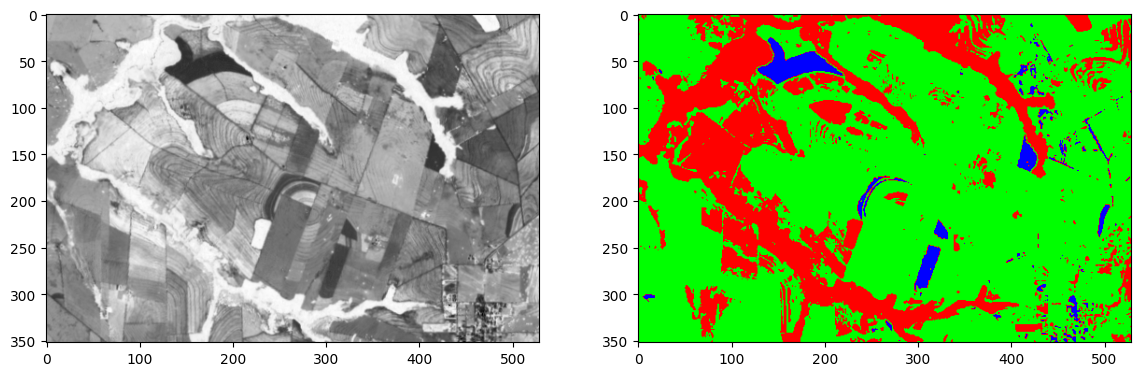

In [20]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(14, 14))
ax1.imshow(ndvi, cmap='gray')
ax2.imshow(labeled_img, cmap='brg');

Now we can apply the difference between images 

In [21]:
first_item = items[17]
second_item = items[0]

In [22]:
first_item 

<Item id=S2-16D_V2_023030_20220101>

In [23]:
second_item

<Item id=S2-16D_V2_023030_20220930>

Sentinel 2 has a specific NDVI band and we can directly read the two images with this band

In [24]:
ndvi_first_image = read(first_item.assets['NDVI'].href, bbox=bbox)
ndvi_second_image = read(second_item.assets['NDVI'].href, bbox=bbox)

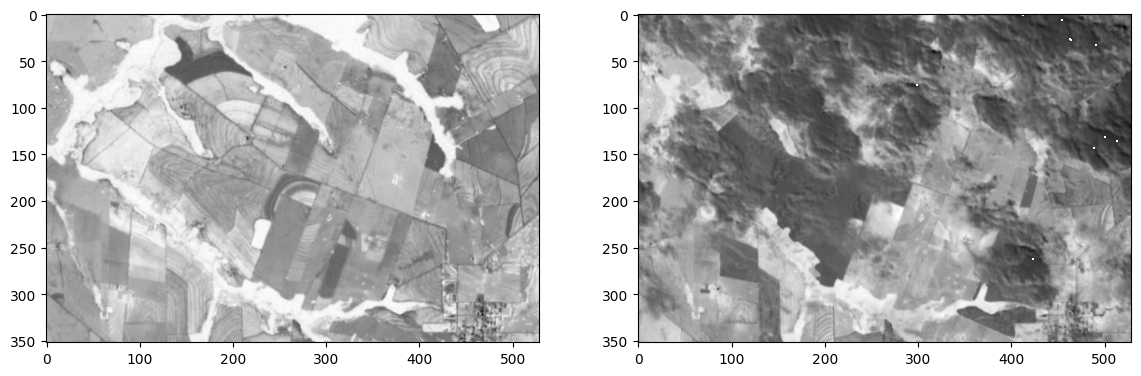

In [25]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 14))    
ax1.imshow(ndvi_first_image, cmap='gray')
ax2.imshow(ndvi_second_image, cmap='gray')

Now you can calculate the difference between the two images, so you can analyze how the flora of the area has changed over time

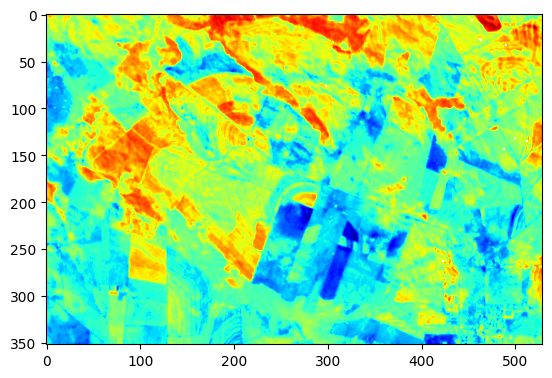

In [26]:
ndvi_diff = ndvi_first_image - ndvi_second_image
plt.imshow(ndvi_diff, cmap='jet');

The blue values indicate negative values, while red values are positive. 
This means that for the blue areas there was a loss of vegetation, as a decreasing result on the NDVI value.
Meanwhile, on the red areas, the NDVI value increased as a result of the more 
vigorous vegetation on the recent date.
